#### Install Library

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
!pip install sentence_transformers Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.4 MB/s 
     |████████████████████████████████| 209 kB 41.3 MB/s 
     |████████████████████████████████| 4.9 MB 50.5 MB/s 
     |████████████████████████████████| 1.3 MB 68.8 MB/s 
     |████████████████████████████████| 163 kB 72.8 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d8f29db7204c845c4e3db5f4701bd5091819a39aab350a22cfe022142535fac9
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch_pretrained_bert nmslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 7.5 MB/s 
     |████████████████████████████████| 13.5 MB 26.3 MB/s 
     |████████████████████████████████| 132 kB 71.0 MB/s 
     |████████████████████████████████| 188 kB 72.1 MB/s 
     |████████████████████████████████| 79 kB 10.8 MB/s 
     |████████████████████████████████| 9.2 MB 52.4 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 127 kB 64.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Import Library

In [ ]:
# Base
from google.colab import files
import pandas as pd
import numpy as np
import re

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from sentence_transformers import SentenceTransformer

# Stemmer Package Khusus Bahasa Indonesia 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()


# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk Gensim BERT
import nmslib
import torch
import random
from tqdm import tqdm
import numpy as np
from joblib import dump, load
from string import punctuation
from operator import itemgetter
from functools import wraps
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset & Analize

In [ ]:
# file upload
from google.colab import files
uploaded = files.upload()

Saving dataset.xlsx to dataset.xlsx


In [ ]:
# data = pd.read_csv('dataset.csv', names=["id_deskripsi", "deskripsi", "id_video", "id_user", "created_at"]) # load dataset .csv
data = pd.read_excel('dataset.xlsx', names=["id_deskripsi", "deskripsi", "id_video", "id_user", "created_at"]) # load dataset .xlsx
data.head()

,id_deskripsi,deskripsi,id_video,id_user,created_at
0,1,Lelaki berjenggot itu sedang menggunting kerta...,11,8,29/04/2016
1,4,pria sedang menggunting kertas,11,38,28/04/2016
2,5,menggunting kertas,11,19,28/04/2016
3,6,Seorang bapak sedang menggunting selembar kertas,11,16,28/04/2016
4,7,ada anjing dan orang perempuan,13,38,28/04/2016


In [ ]:
# melakukan backup dataset dengan copy dataset dan disimpan ke variable df
df = data.copy()

# melakukan drop pada kolom created_at dan id_user
df = df.drop(columns=['id_deskripsi','id_user', 'created_at'])
df.head()

,deskripsi,id_video
0,Lelaki berjenggot itu sedang menggunting kerta...,11
1,pria sedang menggunting kertas,11
2,menggunting kertas,11
3,Seorang bapak sedang menggunting selembar kertas,11
4,ada anjing dan orang perempuan,13


In [ ]:
# memastikan setiap data pada kolom deskripsi merupakan data string
df['deskripsi'] = [str(txt) for txt in df['deskripsi']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43753 entries, 0 to 43752
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deskripsi  43753 non-null  object
 1   id_video   43753 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 683.8+ KB


In [ ]:
total_duplicated = 0
for dup in df.duplicated():
  if dup :
    total_duplicated += 1

print("Total Data yang terduplikat = ", total_duplicated)

Total Data yang terduplikat =  5240


# Split Data Training dan Testing
Data Training = 70% <br>
Data Testing = 30%

In [ ]:
import math
def split_train_test(data, test_size=0.3):
  train_len = math.ceil(len(data) * (100-(test_size*100)) / 100)

  train_data = data[:train_len]
  test_data = data[train_len:]

  return train_data, test_data

In [ ]:
train_df, test_df = split_train_test(df, test_size=0.3)
print("Shape Data Train : ", train_df.shape)
print("Shape Data Test : ", test_df.shape)

Shape Data Train :  (30628, 2)
Shape Data Test :  (13125, 2)


# Preprocess Text & Data Preparation Functions

In [ ]:
# menambah stopword dari library sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()

stoplist = set(stopwords.words('indonesian'))
stoplist_sastrawi = stop_factory.get_stop_words()

intersection = []
for kata in stoplist:
  if kata in stoplist_sastrawi:
    intersection.append(kata)

more_stopwords = []
for word in stoplist_sastrawi:
  if word not in intersection:
    more_stopwords.append(word)

In [ ]:
class NLP:
  def __init__(self, data):
    self.data = data.copy()

  def simple_preprocessing(self, txt, remove_stopwords=True, tokenize=False):
    # lower the text
    text = txt.lower()
    
    # remove url
    text = re.sub(r'((www.\.[^\s]+)|(https?://[^\s]+))', '', text)

    # remove special characters
    text = re.sub(r'\W', ' ', text)

    # remove single character from the start
    text = re.sub(r'\^[A-Za-z]\s+', ' ', text)

    # remove number
    text = re.sub(r'[0-9]+', '', text)

    # remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # remove single character
    text = re.sub(r'\s+[A-Za-z]\s+', ' ', text)
    
    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # remove stopwords
    if remove_stopwords:
      stopword = set(stopwords.words('indonesian')+more_stopwords)
      text = ' '.join([word for word in word_tokenize(text) if word not in stopword])

    if tokenize:
      text = word_tokenize(text)

    return text

  def preprocess_df(self, column='deskripsi', remove_stopwords=True):
    self.data['cleaned_text'] = self.data[column].apply(self.simple_preprocessing)

  def preprocess_text(self, remove_stopwords=True, tokenize=False):
    self.data[0] = self.simple_preprocessing(self.data[0],
                                              tokenize=tokenize)

    if tokenize:
      self.data = list(np.array(self.data[0]).flatten())
    

In [ ]:
def find_distance(sent1, sent2, distance):
  sent1_embedd = sent1.reshape(1,-1)

  nilai_distance = distance(sent1_embedd, sent2)
  return nilai_distance

# Preprocessing

In [ ]:
train_df = NLP(train_df)
train_df.preprocess_df()

In [ ]:
train_df.data

,deskripsi,id_video,cleaned_text
0,Lelaki berjenggot itu sedang menggunting kerta...,11,lelaki berjenggot menggunting kertasnya
1,pria sedang menggunting kertas,11,pria menggunting kertas
2,menggunting kertas,11,menggunting kertas
3,Seorang bapak sedang menggunting selembar kertas,11,menggunting selembar kertas
4,ada anjing dan orang perempuan,13,anjing orang perempuan
...,...,...,...
30623,Anak kecil yang mencium bayangannya sendiri di...,1350,anak mencium bayangannya cermin
30624,seseorang sedang memancing lalu di makan hiu,1299,memancing makan hiu
30625,hamster sedang makan kuaci,1374,hamster makan kuaci
30626,memotong mangga denga pisau,1346,memotong mangga denga pisau


# BERT + Pengukuran Jarak

### Gensim BERT

In [ ]:
def singleton(cls):
    instance = None
    @wraps(cls)
    def inner(*args, **kwargs):
        nonlocal instance
        if instance is None:
            instance = cls(*args, **kwargs)
        return instance
    return inner

In [ ]:
class BertEmbedder(object):
    """
    Embedding Wrapper on Bert Multilingual Cased
    """
    def __init__(self, path=''):
        # use self.model_file with a path instead of 'bert-base-uncased' if you have a custom pretrained model
        self.model_file = 'bert-base-multilingual-cased'#os.path.join(path, "bert-base-multilingual-cased.tar.gz")
        self.vocab_file = 'bert-base-multilingual-cased'#os.path.join(path, "data_bert-base-multilingual-cased-vocab.txt")
        self.model = self.bert_model()
        self.tokenizer = self.bert_tokenizer()
        self.embedding_matrix = self.get_bert_embed_matrix()

    @singleton
    def bert_model(self):
        model = BertModel.from_pretrained(self.model_file).eval()
        return model

    @singleton
    def bert_tokenizer(self):
        tokenizer = BertTokenizer.from_pretrained(self.vocab_file, do_lower_case=False) 
        return tokenizer

    @singleton
    def get_bert_embed_matrix(self):
        bert_embeddings = list(self.model.children())[0]
        bert_word_embeddings = list(bert_embeddings.children())[0]
        matrix = bert_word_embeddings.weight.data.numpy()
        return matrix

    def sentence_embedding(self, text):
        token_list = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
        segments_ids, indexed_tokens = [1] * len(token_list), self.tokenizer.convert_tokens_to_ids(token_list)
        segments_tensors, tokens_tensor = torch.tensor([segments_ids]), torch.tensor([indexed_tokens])
        with torch.no_grad():
            encoded_layers, _ = self.model(tokens_tensor, segments_tensors)
        sent_embedding = torch.mean(encoded_layers[11], 1)
        return sent_embedding
    
    def sentences_embedding(self, text_list):
        embeddings = []
        for text in tqdm(text_list):
            token_list = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
            segments_ids, indexed_tokens = [1] * len(token_list), self.tokenizer.convert_tokens_to_ids(token_list)
            segments_tensors, tokens_tensor = torch.tensor([segments_ids]), torch.tensor([indexed_tokens])
            with torch.no_grad():
                encoded_layers, _ = self.model(tokens_tensor, segments_tensors)
            sent_embedding = torch.mean(encoded_layers[11], 1)
            embeddings.append(sent_embedding)
        return embeddings

    def token_embedding(self, token_list):
        token_embedding = []
        for token in token_list:
            ontoken = self.tokenizer.tokenize(token)
            segments_ids, indexed_tokens = [1] * len(ontoken), self.tokenizer.convert_tokens_to_ids(ontoken)
            segments_tensors, tokens_tensor = torch.tensor([segments_ids]), torch.tensor([indexed_tokens])
            with torch.no_grad():
                encoded_layers, _ = self.model(tokens_tensor, segments_tensors)
            ontoken_embeddings = []
            for subtoken_i in range(len(ontoken)):
                hidden_layers = []
                for layer_i in range(len(encoded_layers)):
                    vector = encoded_layers[layer_i][0][subtoken_i]
                    hidden_layers.append(vector)
                ontoken_embeddings.append(hidden_layers)
            cat_last_4_layers = [torch.cat((layer[-4:]), 0) for layer in ontoken_embeddings]
            token_embedding.append(cat_last_4_layers)
        token_embedding = torch.stack(token_embedding[0], 0) if len(token_embedding) > 1 else token_embedding[0][0]
        return token_embedding

In [ ]:
class BertIndexer():
    def __init__(self, bert_model=BertEmbedder()):
        self.model = bert_model
        self.space_type = 'cosinesimil'
        self.method_name = 'hnsw'
        self.index = nmslib.init(space  = self.space_type,
                    method = self.method_name,
                    data_type = nmslib.DataType.DENSE_VECTOR,
                    dtype = nmslib.DistType.FLOAT)
        self.index_params = {'NN' : 15}
        self.index_is_loaded = False
        self.data = []

        class IndexError(Exception):
            """Base class for other exceptions"""
            pass
        
    def load_index(self, index_path, data):
        self.index.loadIndex( index_path, load_data=True)
        self.index_is_loaded = True
        self.data = data

    def create_index(self, index_path, data):
        names_sparse_matrix = self.make_data_embeddings(data)
        self.index.addDataPointBatch(data = names_sparse_matrix)
        self.index.createIndex( print_progress=True)
        self.index.saveIndex(index_path, save_data=True)
        self.index_is_loaded = True
        self.data = data
    
    def create_embedding(self, text):
        return self.model.sentence_embedding(text).numpy()
        
    def make_data_embeddings(self, data):
        names_sparse_matrix = []
        for i in tqdm(range(len(data))):
            try:
                names_sparse_matrix.append(self.model.sentence_embedding(data[i])[0].numpy())
            except:
                names_sparse_matrix.append(np.zeros(768))
        return names_sparse_matrix

    def return_closest(self, text, k=2, num_threads=2):
        if self.index_is_loaded:
            r = self.model.sentence_embedding(text).numpy()
            near_neighbors = self.index.knnQueryBatch(queries=[r], k=k, num_threads=num_threads)
            return [self.data[i] for i in near_neighbors[0][0]]
        else: raise IndexError("Index is not yet created or loaded")

100%|██████████| 995526/995526 [00:00<00:00, 3189087.08B/s]


### Word Embedding

In [ ]:
indexer = BertIndexer()

In [ ]:
sentences = train_df.data['cleaned_text']
embedding = indexer.make_data_embeddings(sentences)

100%|██████████| 30628/30628 [35:06<00:00, 14.54it/s]


In [ ]:
len(embedding)

30628

In [ ]:
test_df = NLP(test_df)
test_df.preprocess_df()

In [ ]:
np.array(embedding).shape

(30628, 768)

### Visualisasi Padding

In [ ]:
# mengambil nilai embedding
result_embed = {}
list_embed = []
list_pad = []

for list_ in embedding[:10]: # mengambil sample 10 baris data
  jml_embed = 0
  jml_pad = 0
  for angka in list_:
    if angka != 0:
      jml_embed += 1
    else:
      jml_pad += 1
  
  list_embed.append(jml_embed)
  list_pad.append(jml_pad)

result_embed['embed'] = list_embed
result_embed['padding'] = list_pad
plot_df = pd.DataFrame(result_embed)

In [ ]:
plot_df

,embed,padding
0,768,0
1,768,0
2,768,0
3,768,0
4,768,0
5,768,0
6,768,0
7,768,0
8,768,0
9,768,0


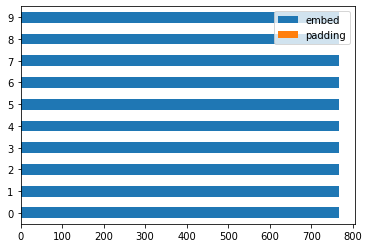

In [ ]:
plot_df.plot.barh(stacked=True);

### BERT + Cosine Similarity

In [ ]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Testing
sample_text = random.sample(test_df.data['cleaned_text'].tolist(), 1)[0]
confidence = 0.5
result_list_cosine = []
result_df_cosine = []
relevant_list_cosine = []

# ubah kata ke bentuk vector
sample_embedd = indexer.create_embedding(sample_text)
score_cosine = find_distance(sample_embedd, embedding, cosine_similarity)
score_cosine

array([[0.773796  , 0.76616627, 0.72935987, ..., 0.7500043 , 0.689734  ,
        0.775446  ]], dtype=float32)

In [ ]:
# sort data berdasarkan threshold
for score in score_cosine:
  score = [value for value in score]
  result_list_cosine = score

for sent, id_video, score in zip(df['deskripsi'], df['id_video'], result_list_cosine):
  if score >= confidence:
    result_df_cosine.append((id_video, sent, score))
    relevant_list_cosine.append(score)

In [ ]:
print("Sample Text : ", sample_text)

top = 10
result = pd.DataFrame(result_df_cosine, columns=['id_video', 'deskripsi', 'similarity_score'])
result = result.drop_duplicates(subset='id_video')
display(result.sort_values('similarity_score', ascending=False).head(top))

Sample Text :  anjing bermain papan luncur


,id_video,deskripsi,similarity_score
30183,1393,sedang bermain Papan luncur,0.954080
15701,656,bermain papan seluncur di air,0.928312
15679,655,lomba papan seluncur,0.890082
29442,1279,Anjing bermain dengan cermin,0.877806
23928,1008,Anjing bermain balon,0.869025
16941,741,anjing bermain air,0.867775
29317,1253,anjing sedang bermain boneka,0.866286
3015,130,dua ekor anjing sedang bermain dan bercanda,0.865809
30383,1351,kucing dan anjing sedang bermain,0.864381
1894,95,anjing yang sedang bermain basket,0.860221


### BERT + Jaccard

In [ ]:
def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1[0]).intersection(list2)))
    union = (len(list1[0]) + len(list2)) - intersection
    return (float(intersection) / union) *1000

In [ ]:
# Testing
sample_text = random.sample(test_df.data['cleaned_text'].tolist(), 1)[0]
confidence = 0.5
result_list_jaccard = []
result_df_jaccard = []
relevant_list_jaccard = []

# ubah kata ke bentuk vector
sample_embedd = indexer.create_embedding(sample_text)

jaccard_sim_scores = []
for desc in embedding:
  sim_score = jaccard_set(sample_embedd, desc)
  jaccard_sim_scores.append(sim_score)

In [ ]:
# sort data berdasarkan threshold
# for score in jaccard_sim_scores:
#   score = [value for value in score]
#   result_list = score
result_list_jaccard = jaccard_sim_scores

for sent, id_video, score in zip(df['deskripsi'], df['id_video'], result_list_jaccard):
  if score >= confidence:
    result_df_jaccard.append((id_video, sent, score))
    relevant_list_jaccard.append(score)

In [ ]:
print("Sample Text: ", sample_text)

top = 10
result = pd.DataFrame(result_df_jaccard, columns=['id_video', 'deskripsi', 'similarity_score'])
result = result.drop_duplicates()
display(result.sort_values('similarity_score', ascending=False).head(top))

Sample Text:  memotong kayu


,id_video,deskripsi,similarity_score
185,1147,seseorang memotong kayu,1000.000000
175,1147,memotong kayu yang baik dan benar,1000.000000
138,774,Memotong kayu,1000.000000
134,704,Sedang memotong kayu,1000.000000
179,1147,aku sedang memotong kayu,1000.000000
178,1147,sedang memotong kayu,1000.000000
126,705,memotong kayu,1000.000000
139,774,memotong kayu,1000.000000
153,895,memasukkan minyak di atas penggorengan,0.651466
157,966,orang berteriak teriak,0.651466


### BERT + Euclidean

In [ ]:
# eulidean distance
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# Testing
sample_text = random.sample(test_df.data['cleaned_text'].tolist(), 1)[0]
result_list_euclid = []
result_df_euclid = []
relevant_list_euclid = []

# ubah kata ke bentuk vector
sample_embedd = indexer.create_embedding(sample_text)
score_euclid = find_distance(sample_embedd, embedding, euclidean_distances)
score_euclid

array([[4.690766 , 4.460666 , 4.3395424, ..., 4.5867467, 4.43671  ,
        5.5639763]], dtype=float32)

In [ ]:
import math

confidence = math.ceil(min(score_euclid[0]))
print("Nilai Confindence: ", confidence)

Nilai Confindence:  0


In [ ]:
# sort data berdasarkan threshold
for score in score_euclid:
  score = [value for value in score]
  result_list_euclid = score

for sent, id_video, score in zip(df['deskripsi'], df['id_video'], result_list_euclid):
  if score <= confidence:
    result_df_euclid.append((id_video, sent, score))
    relevant_list_euclid.append(score)

In [ ]:
print("Sample Text: ", sample_text)

top = 10
result = pd.DataFrame(result_df_euclid, columns=['id_video', 'deskripsi', 'similarity_score'])
result = result.drop_duplicates()
display(result.sort_values('similarity_score', ascending=True).head(top))

Sample Text:  mengaduk adonan kue


,id_video,deskripsi,similarity_score
0,17,mengaduk adonan kue,0.0
1,210,mengaduk adonan kue,0.0
2,309,mengaduk adonan kue,0.0
3,1165,mengaduk adonan kue,0.0


### BERT + Manhattan

In [ ]:
# manhattan distance
from sklearn.metrics.pairwise import manhattan_distances

In [ ]:
# Testing
sample_text = random.sample(test_df.data['cleaned_text'].tolist(), 1)[0]
confidence = 0.5
result_list_manhattan = []
result_df_manhattan = []
relevant_list_manhattan = []

# ubah kata ke bentuk vector
sample_embedd = indexer.create_embedding(sample_text)
score_manhattan = find_distance(sample_embedd, embedding, manhattan_distances)
score_manhattan

array([[107.97371084, 115.76713689, 117.8719371 , ..., 106.91433379,
        114.40286477, 116.53255736]])

In [ ]:
import math

confidence = math.ceil(min(score_manhattan[0]))
print("Nilai Confidence: ", confidence)

Nilai Confidence:  79


In [ ]:
# sort data berdasarkan threshold
for score in score_manhattan:
  score = [value for value in score]
  result_list_manhattan = score

for sent, id_video, score in zip(df['deskripsi'], df['id_video'], result_list_manhattan):
  if score <= confidence+20:
    result_df_manhattan.append((id_video, sent, score))
    relevant_list_manhattan.append(score)

In [ ]:
print("Sample Text: ", sample_text)

top = 10
result = pd.DataFrame(result_df_manhattan, columns=['id_video', 'deskripsi', 'similarity_score'])
result = result.drop_duplicates()
display(result.sort_values('similarity_score', ascending=True).head(top))

Sample Text:  kumpulan pinguni salju


,id_video,deskripsi,similarity_score
300,319,orang berkuda di salju,78.207972
819,641,rubah jalan di salju,79.773763
1337,1129,beruang bermain di atas salju,82.025357
1397,1129,beruang sedang bermain di salju,82.025357
1127,960,panda bermain di salju,82.254244
1132,960,panda itu bermain salju,82.254244
1102,959,panda bermain di salju,82.254244
1144,959,panda bermain salju,82.254244
1131,959,panda itu bermain salju,82.254244
1165,960,Panda bermain salju,82.254244


# Evaluasi (Precision, Recall, F-Score)

**Precision**

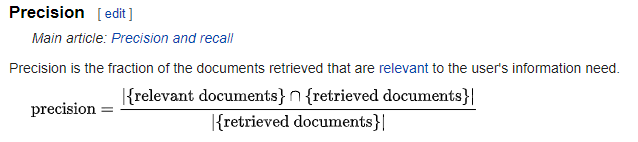

In [ ]:
def precision(relevant, retrieved):
  nominator = len(list(set(relevant).intersection(retrieved)))
  denominator = len(retrieved)
  return nominator / denominator

**Recall** <br>
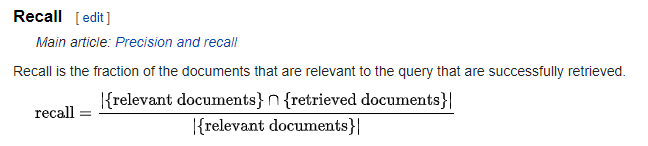

In [ ]:
def recall(relevant, retrieved):
  nominator = len(list(set(relevant).intersection(retrieved)))
  denominator = len(relevant)
  return nominator / denominator

**F-Score** <br>
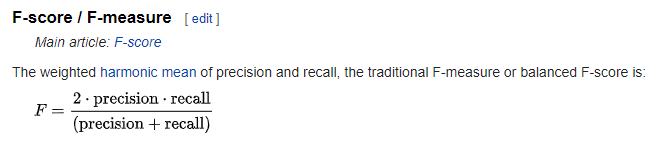

In [ ]:
def f_score(precision, recall):
  return (2 * precision * recall) / (precision + recall)

### Cosine Similarity

In [ ]:
precision_cosine = precision(relevant_list_cosine, result_list_cosine)
recall_cosine = recall(relevant_list_cosine, result_list_cosine)
f_score_cosine = f_score(precision_cosine, recall_cosine)

print("Precision: ", precision_cosine)
print("Recall: ", recall_cosine)
print("F-Score: ", f_score_cosine)

Precision:  0.6348765835183492
Recall:  0.63489731282855
F-Score:  0.6348869480042445


### Jaccard Similarity

In [ ]:
precision_jaccard = precision(relevant_list_jaccard, result_list_jaccard)
recall_jaccard = recall(relevant_list_jaccard, result_list_jaccard)
f_score_jaccard = f_score(precision_jaccard, recall_jaccard)

print("Precision: ", precision_jaccard)
print("Recall: ", recall_jaccard)
print("F-Score: ", f_score_jaccard)

Precision:  6.52997257411519e-05
Recall:  0.009523809523809525
F-Score:  0.00012971009793112393


### Eulidean Disctance

In [ ]:
precision_euclid = precision(relevant_list_euclid, result_list_euclid)
recall_euclid = recall(relevant_list_euclid, result_list_euclid)
f_score_euclid = f_score(precision_euclid, recall_euclid)

print("Precision: ", precision_euclid)
print("Recall: ", recall_euclid)
print("F-Score: ", f_score_euclid)

Precision:  3.264986287057595e-05
Recall:  0.25
F-Score:  6.5291198746409e-05


### Manhattan Distance

In [ ]:
precision_manhattan = precision(relevant_list_manhattan, result_list_manhattan)
recall_manhattan = recall(relevant_list_manhattan, result_list_manhattan)
f_score_manhattan = f_score(precision_manhattan, recall_manhattan)

print("Precision: ", precision_manhattan)
print("Recall: ", recall_manhattan)
print("F-Score: ", f_score_manhattan)

Precision:  0.03558835052892778
Recall:  0.6554419723391461
F-Score:  0.06751107119630857
